# <p style="background-color: #b30024; font-family: Blippo, fantasy; line-height: 1.3; font-size: 26px; letter-spacing: 3px; text-align: center; color: #ffeef1"> Análisis FIFA 2018 - Clustering Complete Dataset </p>

![](https://s.yimg.com/ny/api/res/1.2/sybAk0uKKJIlkVhfz5Jtuw--/YXBwaWQ9aGlnaGxhbmRlcjtzbT0xO3c9ODAw/http://media.zenfs.com/en-GB/homerun/uk.goal.com/42bf6d3fd31612f17e7b59c6260595db)




In [1]:
import numpy as np
import pandas as pd
import os 
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import re#, wget, os

In [2]:
players = pd.read_csv("CompleteDataset.csv",low_memory=False) #guessing dtypes for each column is very memory demanding
player_att = pd.read_csv("PlayerAttributeData.csv",low_memory=False) #to get att names easier
players["PrefPos"] = players["Preferred Positions"].apply(lambda x: re.findall('^([\w\-]+)', x)[0]) # Get first preferred position
# if fowards 0, midfield = 1, defender = 2, GK = 3

positions_map1 = {
 'CAM': 1,
 'CB': 2,
 'CDM': 2,
 'CF': 0,
 'CM': 1,
 'GK': 3,
 'LB': 2,
 'LM': 1,
 'LW': 0,
 'LWB': 2,
 'RB': 2,
 'RM': 1,
 'RW': 0,
 'RWB': 2,
 'ST': 0}

players["PrefPos1"] = players["PrefPos"].replace(positions_map1)
players = players.fillna(0)

def get_attributes(players):
    attribute_names = player_att.columns[1:].values # all attribute names e.g. Acceleration, Aggresion, Agility etc.
    attribute_names = attribute_names[attribute_names!="ID"] # remove id not interested
    attributes = players[attribute_names] #get 
    attributes = attributes.apply(pd.to_numeric, errors='coerce', axis=0) #invalid parsing will be set as NaN
    attributes = attributes.fillna(0)
    return attributes, attribute_names

attributes, attribute_names = get_attributes(players)
position_col = players["PrefPos1"] # for coloring plot

attributes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17981 entries, 0 to 17980
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Acceleration        17981 non-null  float64
 1   Aggression          17981 non-null  float64
 2   Agility             17981 non-null  float64
 3   Balance             17981 non-null  float64
 4   Ball control        17981 non-null  float64
 5   Composure           17981 non-null  float64
 6   Crossing            17981 non-null  float64
 7   Curve               17981 non-null  float64
 8   Dribbling           17981 non-null  float64
 9   Finishing           17981 non-null  float64
 10  Free kick accuracy  17981 non-null  float64
 11  GK diving           17981 non-null  float64
 12  GK handling         17981 non-null  float64
 13  GK kicking          17981 non-null  float64
 14  GK positioning      17981 non-null  float64
 15  GK reflexes         17981 non-null  float64
 16  Head

In [3]:
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17981 entries, 0 to 17980
Data columns (total 77 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           17981 non-null  int64  
 1   Name                 17981 non-null  object 
 2   Age                  17981 non-null  int64  
 3   Photo                17981 non-null  object 
 4   Nationality          17981 non-null  object 
 5   Flag                 17981 non-null  object 
 6   Overall              17981 non-null  int64  
 7   Potential            17981 non-null  int64  
 8   Club                 17981 non-null  object 
 9   Club Logo            17981 non-null  object 
 10  Value                17981 non-null  object 
 11  Wage                 17981 non-null  object 
 12  Special              17981 non-null  int64  
 13  Acceleration         17981 non-null  object 
 14  Aggression           17981 non-null  object 
 15  Agility              17981 non-null 

In [4]:
df = players.copy()
df = df[(df['PrefPos']=='CB') | (df['PrefPos']=='ST') | (df['PrefPos']=='GK') | (df['PrefPos']=='CM')]
df = df.reset_index(drop=True)
df['PrefPos'].value_counts()


CB    2705
ST    2277
GK    2029
CM    1977
Name: PrefPos, dtype: int64

In [5]:

X =df[attribute_names]

X=X.apply(pd.to_numeric, errors='coerce', axis=0)
X=X.fillna(0)
X.head()



,Acceleration,Aggression,Agility,Balance,Ball control,Composure,Crossing,Curve,Dribbling,Finishing,...,Reactions,Short passing,Shot power,Sliding tackle,Sprint speed,Stamina,Standing tackle,Strength,Vision,Volleys
0,89.0,63.0,89.0,63.0,93.0,95.0,85.0,81.0,91.0,94.0,...,96.0,83.0,94.0,23.0,91.0,92.0,31.0,80.0,85.0,88.0
1,88.0,78.0,86.0,60.0,91.0,83.0,77.0,86.0,86.0,94.0,...,93.0,83.0,87.0,38.0,77.0,89.0,45.0,80.0,84.0,88.0
2,58.0,29.0,52.0,35.0,48.0,70.0,15.0,14.0,30.0,13.0,...,85.0,55.0,25.0,11.0,61.0,44.0,10.0,83.0,70.0,11.0
3,79.0,80.0,78.0,80.0,89.0,87.0,62.0,77.0,85.0,91.0,...,91.0,83.0,88.0,19.0,83.0,79.0,42.0,84.0,78.0,87.0
4,57.0,38.0,60.0,43.0,42.0,64.0,17.0,21.0,18.0,13.0,...,88.0,50.0,31.0,13.0,58.0,40.0,21.0,64.0,68.0,13.0


In [6]:
df = pd.concat([X,df['PrefPos'],df['Overall'], df['Age'],df['Name']],axis=1)
            
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8988 entries, 0 to 8987
Data columns (total 38 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Acceleration        8988 non-null   float64
 1   Aggression          8988 non-null   float64
 2   Agility             8988 non-null   float64
 3   Balance             8988 non-null   float64
 4   Ball control        8988 non-null   float64
 5   Composure           8988 non-null   float64
 6   Crossing            8988 non-null   float64
 7   Curve               8988 non-null   float64
 8   Dribbling           8988 non-null   float64
 9   Finishing           8988 non-null   float64
 10  Free kick accuracy  8988 non-null   float64
 11  GK diving           8988 non-null   float64
 12  GK handling         8988 non-null   float64
 13  GK kicking          8988 non-null   float64
 14  GK positioning      8988 non-null   float64
 15  GK reflexes         8988 non-null   float64
 16  Headin

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
scaler = MinMaxScaler()
attributes_n=scaler.fit_transform(X)

<Figure size 720x720 with 0 Axes>

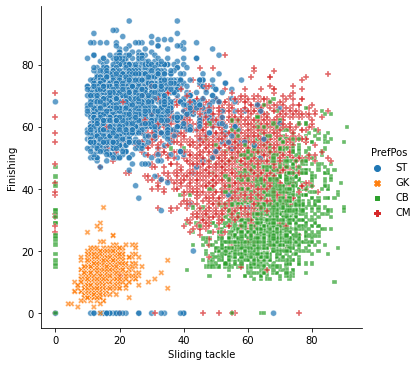

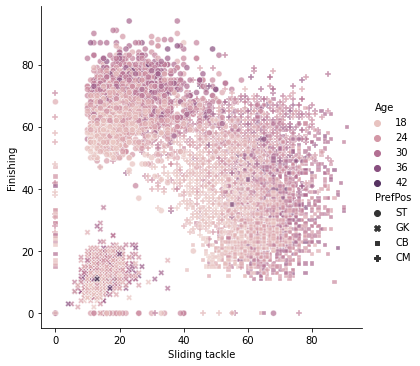

In [8]:
#Visualising the data for 3 specialised positions

import seaborn as sns
plt.figure(figsize=(10,10))

sns.relplot(x="Sliding tackle", 
                y="Finishing", 
                hue="PrefPos", 
                kind="scatter", 
                style = 'PrefPos',
                data=df,#[(df['PrefPos']=='CB') | (df['PrefPos']=='ST') | (df['PrefPos']=='GK') | (df['PrefPos']=='CM')], 
                alpha = 0.7)

sns.relplot(x="Sliding tackle", 
                y="Finishing", 
                hue="Age", 
                kind="scatter", 
                style = 'PrefPos',
                data=df,#[(df['PrefPos']=='CB') | (df['PrefPos']=='ST') | (df['PrefPos']=='GK') | (df['PrefPos']=='CM')], 
                alpha = 0.7)

plt.show()

In [9]:


from sklearn.decomposition import PCA
dim_reduce = PCA() #dim reduction
dim_reduce_fit = dim_reduce.fit_transform(X) 

explained_variance=dim_reduce.explained_variance_ratio_
cum_var_exp = np.cumsum(explained_variance) # Cumulative explained variance
print(list(zip(range(34),cum_var_exp)))


[(0, 0.6242712699852796), (1, 0.7805347856737936), (2, 0.8311697161995801), (3, 0.8619522073698209), (4, 0.8862553295041183), (5, 0.8964635712060693), (6, 0.9056024681873611), (7, 0.9131477882572591), (8, 0.9199129410873934), (9, 0.9264930284614982), (10, 0.9327301641554151), (11, 0.9381593142626408), (12, 0.9432592564909767), (13, 0.9481339057837266), (14, 0.9526238451422108), (15, 0.9569087929337976), (16, 0.9606783661427121), (17, 0.9642528775942445), (18, 0.9677925059646015), (19, 0.971130528710311), (20, 0.9743904435487766), (21, 0.9774415398704608), (22, 0.9803534954351577), (23, 0.983052729123615), (24, 0.9856063101092873), (25, 0.9877594211091475), (26, 0.9898535526889395), (27, 0.9918558594128973), (28, 0.9936589210727766), (29, 0.9951836850197517), (30, 0.9965291717654594), (31, 0.9978379614351266), (32, 0.9989395433687079), (33, 0.9999999999999999)]


In [10]:
xs = dim_reduce_fit[:,0]
ys = dim_reduce_fit[:,1]

df['xs']=xs
df['ys']=ys

In [11]:
from sklearn.cluster import KMeans
def dim_reduction(x):
    dim_reduce = PCA(n_components=15) #dim reduction
    dim_reduce_fit = dim_reduce.fit_transform(x) 
    return dim_reduce, dim_reduce_fit

dim_reduce, dim_reduce_fit = dim_reduction(X)


kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 1)
y_kmeans = kmeans.fit_predict(dim_reduce_fit )


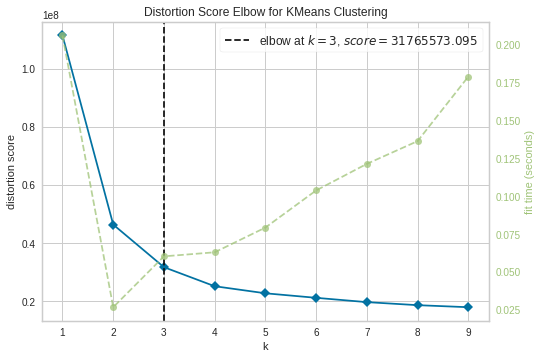

In [12]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
fig = KElbowVisualizer(model,k=(1,10))
fig.fit(dim_reduce_fit)
fig.show();

In [13]:
df['y_kmeans']=y_kmeans

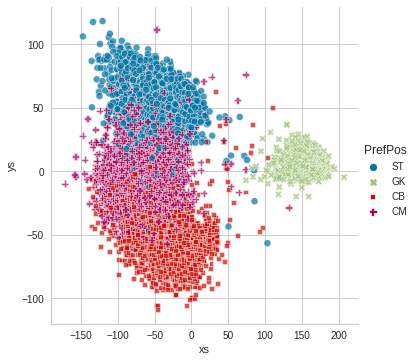

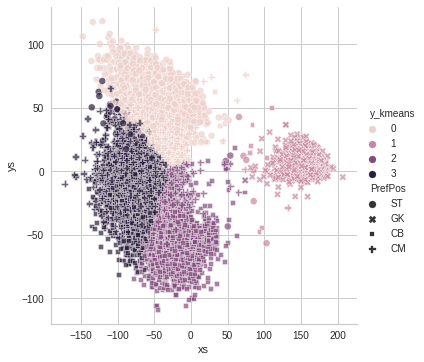

In [14]:
import seaborn as sns
xs = dim_reduce_fit[:,0]
ys = dim_reduce_fit[:,1]
df['xs']=xs
g = sns.relplot(x='xs', 
                y='ys', 
                hue="PrefPos", 
                kind="scatter", 
                style = 'PrefPos',
                data=df,#[(df['PrefPos']=='CB') | (df['PrefPos']=='ST') | (df['PrefPos']=='GK') | (df['PrefPos']=='CM')], 
                alpha = 0.7)

g = sns.relplot(x='xs', 
                y='ys', 
                hue="y_kmeans", 
                kind="scatter", 
                style = 'PrefPos',
                data=df,#[(df['PrefPos']=='CB') | (df['PrefPos']=='ST') | (df['PrefPos']=='GK') | (df['PrefPos']=='CM')], 
                alpha = 0.7)


In [15]:
fifacluster = pd.DataFrame(dim_reduce_fit)
fifacluster['cluster'] = y_kmeans
fifacluster['GPOS'] = df['PrefPos']

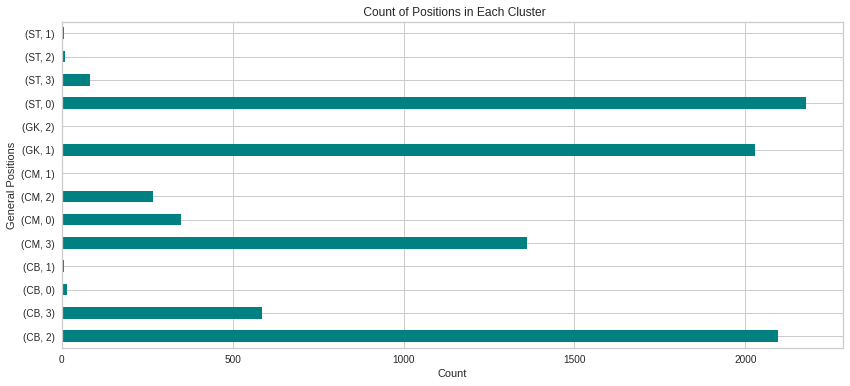

In [16]:
fifacluster.groupby("GPOS")["cluster"].value_counts().plot(kind="barh",color="teal",figsize=(14,6))
plt.ylabel('General Positions')
plt.xlabel('Count')
plt.title(' Count of Positions in Each Cluster')
plt.show()
#fowards 0, midfield = 1, defender = 2, GK = 3

In [17]:
pd.crosstab( index=fifacluster['cluster'],columns=fifacluster['GPOS'])
#fowards 0, midfield = 1, defender = 2, GK = 3

GPOS,CB,CM,GK,ST
cluster,,,,
0,14,349,0,2177
1,7,2,2028,7
2,2097,266,1,10
3,587,1360,0,83


In [18]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 1)
y_kmeans2 = kmeans.fit_predict(df[['Sliding tackle','Finishing']] )
df['y_kmeans2']=y_kmeans2
fifacluster['cluster2'] = y_kmeans2

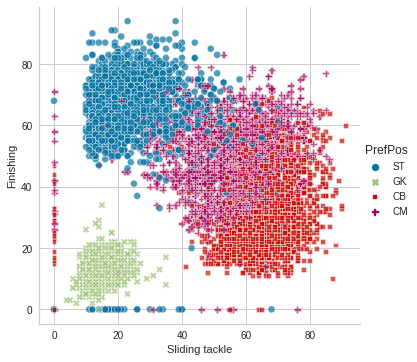

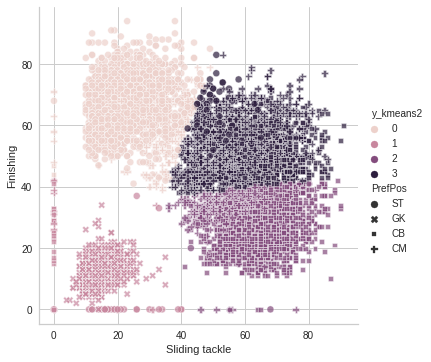

In [19]:


g = sns.relplot(x="Sliding tackle", 
                y="Finishing", 
                hue="PrefPos", 
                kind="scatter", 
                style = 'PrefPos',
                data=df[(df['PrefPos']=='CB') | (df['PrefPos']=='ST') | (df['PrefPos']=='GK') | (df['PrefPos']=='CM')], 
                alpha = 0.7)

g = sns.relplot(x="Sliding tackle", 
                y="Finishing", 
                hue="y_kmeans2", 
                kind="scatter", 
                style = 'PrefPos',
                data=df[(df['PrefPos']=='CB') | (df['PrefPos']=='ST') | (df['PrefPos']=='GK') | (df['PrefPos']=='CM')], 
                alpha = 0.7)


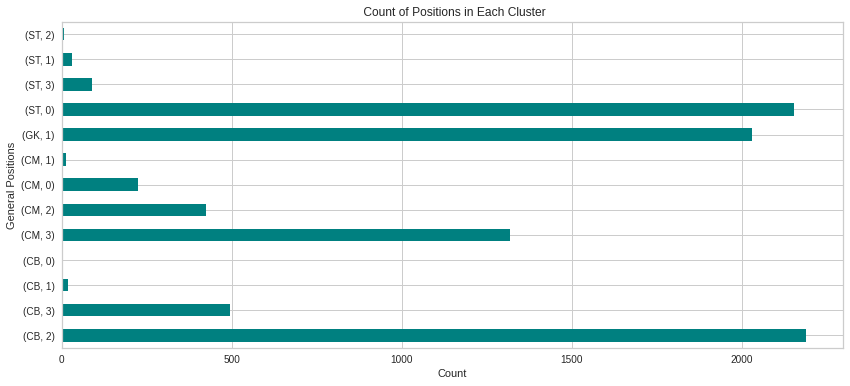

In [20]:
fifacluster.groupby("GPOS")["cluster2"].value_counts().plot(kind="barh",color="teal",figsize=(14,6))
plt.ylabel('General Positions')
plt.xlabel('Count')
plt.title(' Count of Positions in Each Cluster')
plt.show()
#fowards 0, midfield = 1, defender = 2, GK = 3

In [21]:
pd.crosstab( index=fifacluster['cluster2'],columns=fifacluster['GPOS'])
#fowards 0, midfield = 1, defender = 2, GK = 3

GPOS,CB,CM,GK,ST
cluster2,,,,
0,3,224,0,2153
1,19,13,2029,31
2,2188,423,0,5
3,495,1317,0,88


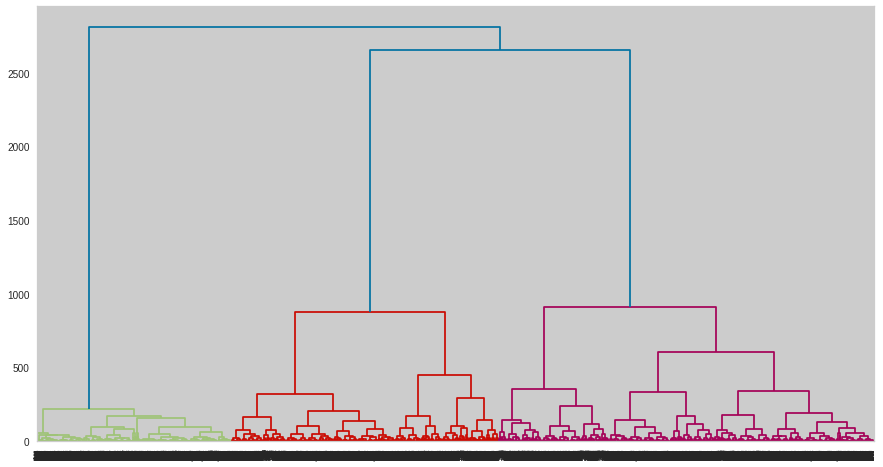

In [22]:
from scipy.cluster.vq import whiten
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import warnings
warnings.filterwarnings('ignore')
# Fit the data into hierarchical clustering algorithm
dm = linkage(df[['Sliding tackle', 'Finishing']], method='ward')

# Create a dendrogram
plt.figure(figsize=(15,8))
dendr = dendrogram(dm)
plt.show()

In [23]:
# Assign cluster label to each row
df['labels'] = fcluster(dm, 4, criterion = 'maxclust')
fifacluster['cluster3'] = df['labels']

In [24]:
 #Print cluster centers of each cluster
print(df.groupby('labels')['Sliding tackle', 'Finishing'].mean())

        Sliding tackle  Finishing
labels                           
1            14.032967  12.464883
2            28.189613  64.680376
3            69.737553  50.170464
4            61.209785  29.592045


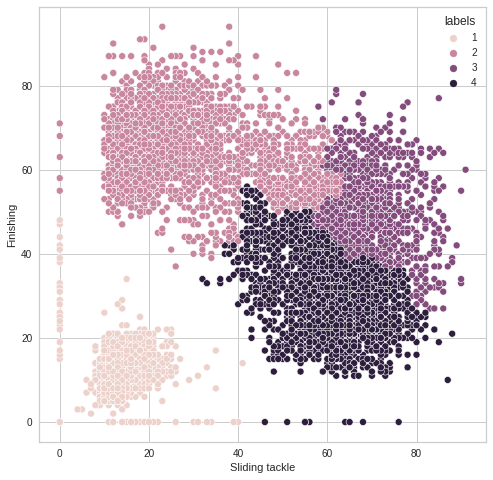

In [25]:
# Create the scatterplot
plt.figure(figsize=(8,8))
sns.scatterplot(x='Sliding tackle', y='Finishing', hue='labels', data=df)
plt.show()

In [26]:
# Identify 5 players of each cluster
for cluster in df['labels'].unique():
    print(cluster, df[df['labels']==cluster]['Name'].values[:5])

2 ['Cristiano Ronaldo' 'L. Suárez' 'R. Lewandowski' 'G. Higuaín' 'S. Agüero']
1 ['M. Neuer' 'De Gea' 'T. Courtois' 'G. Buffon' 'J. Oblak']
3 ['Sergio Ramos' 'G. Chiellini' 'L. Bonucci' 'J. Boateng' 'D. Godín']
4 ['A. Barzagli' 'K. Koulibaly' 'K. Manolas' 'N. Süle' 'S. de Vrij']


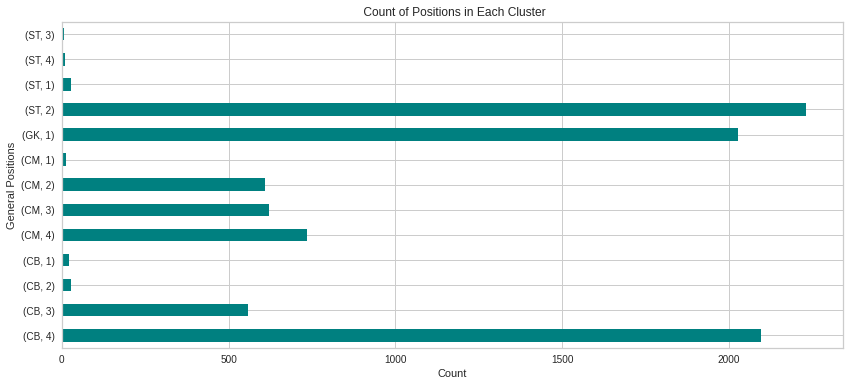

In [27]:
fifacluster.groupby("GPOS")["cluster3"].value_counts().plot(kind="barh",color="teal",figsize=(14,6))
plt.ylabel('General Positions')
plt.xlabel('Count')
plt.title(' Count of Positions in Each Cluster')
plt.show()
#fowards 0, midfield = 1, defender = 2, GK = 3

In [28]:
pd.crosstab( index=fifacluster['cluster3'],columns=fifacluster['GPOS'])
#fowards 0, midfield = 1, defender = 2, GK = 3

GPOS,CB,CM,GK,ST
cluster3,,,,
1,22,13,2029,29
2,29,609,0,2231
3,558,620,0,7
4,2096,735,0,10
